In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# print all columns 
pd.set_option('display.max_columns', None)

# Import Data

In [2]:
data = pd.read_csv('../DataOut/bus_trip_speed_and_other_features.csv')
# import bus trips
bus_trips = pd.read_csv("../DataOut/bus_trips.csv")

# load the csv Data Sets\route points.csv 
route_points = pd.read_csv("../Data Sets/route points.csv")

In [3]:
data

,deviceid,devicetime,latitude,longitude,speed,date,time,bus_stop,trip_id,direction,acceleration,radial_acceleration,distance_from_start,time_diff,acc_diff,acceleration_der,segment
0,116,2021-10-16 08:03:19,7.293068,80.636430,14.03890,2021-10-16,08:03:19,0,2.0,1,0.323975,0.000000,0.000000,NaN,NaN,0.000000,1
1,116,2021-10-16 08:03:34,7.293043,80.637552,10.25920,2021-10-16,08:03:34,0,2.0,1,-0.251980,1.278067,123.738485,0 days 00:00:15,-0.575955,-0.038397,1
2,116,2021-10-16 08:03:49,7.292725,80.637707,7.55940,2021-10-16,08:03:49,0,2.0,1,-0.179987,0.722300,163.044397,0 days 00:00:15,0.071993,0.004800,1
3,116,2021-10-16 08:04:04,7.292292,80.637663,3.77970,2021-10-16,08:04:04,0,2.0,1,-0.251980,0.048332,211.472339,0 days 00:00:15,-0.071993,-0.004800,1
4,116,2021-10-16 08:04:19,7.291640,80.637455,9.17927,2021-10-16,08:04:19,101,2.0,1,0.359971,1.052222,287.492821,0 days 00:00:15,0.611951,0.040797,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034419,1719,2022-02-25 16:47:53,7.291572,80.635452,2.15983,2022-02-25,16:47:53,0,15890.0,2,0.215983,0.714925,16242.694984,0 days 00:00:10,2.105833,0.210583,0
4034420,1719,2022-02-25 16:47:57,7.291587,80.635355,2.15983,2022-02-25,16:47:57,0,15890.0,2,0.000000,0.003500,16253.479312,0 days 00:00:04,-0.215983,-0.053996,0
4034421,1719,2022-02-25 16:48:02,7.291597,80.635293,3.77970,2022-02-25,16:48:02,0,15890.0,2,0.323974,1.320196,16260.374802,0 days 00:00:05,0.323974,0.064795,0
4034422,1719,2022-02-25 16:48:03,7.291605,80.635280,3.77970,2022-02-25,16:48:03,0,15890.0,2,0.000000,0.128080,16262.113859,0 days 00:00:01,-0.323974,-0.323974,0


In [4]:
# detects trips with not enought gps points and removes them
data['count'] = data.groupby('trip_id')['trip_id'].transform('count')
print(data['count'].mean())

# print a complete list of trip ids that count less than 50
print(data[data['count'] < 50]['trip_id'].unique())
# drop trips with less than 50 gps points
data = data[data['count'] > 50].copy()

607.25928856263
[]


## prepare data

In [5]:
#  date is do we will not include testing data in the clustering
data=data[data['direction']==1]
data_selected=data[data['date']<'2022-10-01'].copy()
data_test_selected=data[data['date']>='2022-10-01'].copy()

data_to_cluster=data_selected[['trip_id','deviceid','segment','speed','acceleration','radial_acceleration','acceleration_der']]
data_to_test=data_test_selected[['trip_id','deviceid','segment','speed','acceleration','radial_acceleration','acceleration_der']]

# reset index
data_to_cluster=data_to_cluster.reset_index(drop=True)
data_to_test=data_to_test.reset_index(drop=True)

# data_to_cluster drop rows where segment is 0
data_to_cluster=data_to_cluster[data_to_cluster['segment']!=0].copy()
data_to_test=data_to_test[data_to_test['segment']!=0].copy()

In [6]:
data_to_cluster

,trip_id,deviceid,segment,speed,acceleration,radial_acceleration,acceleration_der
0,2.0,116,1,14.03890,0.323975,0.000000,0.000000
1,2.0,116,1,10.25920,-0.251980,1.278067,-0.038397
2,2.0,116,1,7.55940,-0.179987,0.722300,0.004800
3,2.0,116,1,3.77970,-0.251980,0.048332,-0.004800
4,2.0,116,1,9.17927,0.359971,1.052222,0.040797
...,...,...,...,...,...,...,...
1812608,15891.0,1719,15,0.00000,0.000000,0.000000,0.377970
1812609,15891.0,1719,15,4.31966,0.617094,0.038529,0.088156
1812610,15891.0,1719,15,4.85961,0.539950,0.174790,-0.077144
1812611,15891.0,1719,15,8.09935,1.619870,1.210652,0.539960


In [7]:
# set Nan in bus_stop to 0
data['bus_stop']=data['bus_stop'].fillna(0)
data_selected['bus_stop']=data_selected['bus_stop'].fillna(0)
data_test_selected['bus_stop']=data_test_selected['bus_stop'].fillna(0)

In [8]:
Cols_for_clusteringDF=['devicetime', 'radial_acceleration','speed', 'acceleration','distance_from_start','acceleration_der','bus_stop']

# Clustering

In [9]:
Dict_of_clusters = {}

# Normal Cluster

In [10]:
features_only_df = data_to_cluster[['speed', 'acceleration', 'radial_acceleration','acceleration_der']]

features_only_df_test = data_to_test[['speed', 'acceleration', 'radial_acceleration','acceleration_der']]

In [11]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# # Assuming you have your preprocessed data in 'data_to_cluster_mean'

# # List to store distortion values
# distortions = []

# # Choose a range of cluster counts to try
# cluster_range = range(1, 11)

# # Calculate distortion for each cluster count
# for num_clusters in cluster_range:
#     kmeans = KMeans(n_clusters=num_clusters, random_state=0)
#     kmeans.fit(features_only_df)
#     distortions.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the nearest cluster center

# # Plot the elbow curve
# plt.plot(cluster_range, distortions, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Distortion')
# plt.title('Elbow Method')
# plt.show()

In [12]:
features_only_df

,speed,acceleration,radial_acceleration,acceleration_der
0,14.03890,0.323975,0.000000,0.000000
1,10.25920,-0.251980,1.278067,-0.038397
2,7.55940,-0.179987,0.722300,0.004800
3,3.77970,-0.251980,0.048332,-0.004800
4,9.17927,0.359971,1.052222,0.040797
...,...,...,...,...
1812608,0.00000,0.000000,0.000000,0.377970
1812609,4.31966,0.617094,0.038529,0.088156
1812610,4.85961,0.539950,0.174790,-0.077144
1812611,8.09935,1.619870,1.210652,0.539960


In [13]:
# # min max scaler for features_only_df
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# features_only_df = scaler.fit_transform(features_only_df)
# features_only_df_test = scaler.fit_transform(features_only_df_test)

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Choose the number of clusters
num_clusters = 3

# Initialize the clustering algorithm
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Fit the algorithm to your data
kmeans.fit(features_only_df)

# Get cluster assignments for each data point
cluster_labels = kmeans.labels_

# Get cluster centers (centroids)
cluster_centers = kmeans.cluster_centers_

# Add cluster labels to your original dataset
data_with_clusters = pd.DataFrame(features_only_df, columns=['speed', 'acceleration', 'radial_acceleration','acceleration_der'])
data_with_clusters['cluster'] = cluster_labels
data_with_clusters['deviceid'] = data_to_cluster['deviceid']  # Add 'deviceid' column from data_to_cluster
data_with_clusters['trip_id'] = data_to_cluster['trip_id']  
data_with_clusters['segment'] = data_to_cluster['segment']

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
# get the cluster values for features_only_df_test using the kmeans model 
cluster_labels_test = kmeans.predict(features_only_df_test)

# Add cluster labels to your original dataset
data_with_clusters_test = pd.DataFrame(features_only_df_test, columns=['speed', 'acceleration', 'radial_acceleration','acceleration_der'])
data_with_clusters_test['cluster'] = cluster_labels_test
data_with_clusters_test['deviceid'] = data_to_test['deviceid']  # Add 'deviceid' column from data_to_cluster
data_with_clusters_test['trip_id'] = data_to_test['trip_id']
data_with_clusters_test['segment'] = data_to_test['segment']
data_with_clusters_test

,speed,acceleration,radial_acceleration,acceleration_der,cluster,deviceid,trip_id,segment
0,16.19870,0.647948,0.000000,0.000000,1,116,847.0,1
1,12.41900,-0.251980,0.150614,-0.059995,0,116,847.0,1
2,7.01944,-0.359971,0.975715,-0.007199,0,116,847.0,1
3,9.17927,0.143989,0.294434,0.033597,0,116,847.0,1
4,2.69978,-0.431966,0.043629,-0.038397,2,116,847.0,1
...,...,...,...,...,...,...,...,...
241847,0.00000,-1.043920,0.000000,-0.076794,2,1377,14366.0,15
241848,8.09935,0.539957,0.017803,0.105592,0,1377,14366.0,15
241849,13.49890,0.359970,1.307136,-0.011999,0,1377,14366.0,15
241850,19.43850,0.395973,2.230684,0.002400,1,1377,14366.0,15


In [16]:
# concatanate data_with_clusters and data_with_clusters_test
data_with_clusters_all=pd.concat([data_with_clusters,data_with_clusters_test])
data_with_clusters_all

,speed,acceleration,radial_acceleration,acceleration_der,cluster,deviceid,trip_id,segment
0,14.03890,0.323975,0.000000,0.000000,0,116,2.0,1
1,10.25920,-0.251980,1.278067,-0.038397,0,116,2.0,1
2,7.55940,-0.179987,0.722300,0.004800,0,116,2.0,1
3,3.77970,-0.251980,0.048332,-0.004800,2,116,2.0,1
4,9.17927,0.359971,1.052222,0.040797,0,116,2.0,1
...,...,...,...,...,...,...,...,...
241847,0.00000,-1.043920,0.000000,-0.076794,2,1377,14366.0,15
241848,8.09935,0.539957,0.017803,0.105592,0,1377,14366.0,15
241849,13.49890,0.359970,1.307136,-0.011999,0,1377,14366.0,15
241850,19.43850,0.395973,2.230684,0.002400,1,1377,14366.0,15


In [17]:
data_with_clusters_all

,speed,acceleration,radial_acceleration,acceleration_der,cluster,deviceid,trip_id,segment
0,14.03890,0.323975,0.000000,0.000000,0,116,2.0,1
1,10.25920,-0.251980,1.278067,-0.038397,0,116,2.0,1
2,7.55940,-0.179987,0.722300,0.004800,0,116,2.0,1
3,3.77970,-0.251980,0.048332,-0.004800,2,116,2.0,1
4,9.17927,0.359971,1.052222,0.040797,0,116,2.0,1
...,...,...,...,...,...,...,...,...
241847,0.00000,-1.043920,0.000000,-0.076794,2,1377,14366.0,15
241848,8.09935,0.539957,0.017803,0.105592,0,1377,14366.0,15
241849,13.49890,0.359970,1.307136,-0.011999,0,1377,14366.0,15
241850,19.43850,0.395973,2.230684,0.002400,1,1377,14366.0,15


In [18]:
Norm_clusters_data=data_with_clusters_all.copy()
import statistics

# Define a custom function to calculate the mode
def select_mode(x):
    if len(x) == 0:
        return None
    elif len(x) == 1:
        return x.iloc[0]  # Return the single mode if there's only one
    else:
        # If there are multiple modes, return one of them
        return statistics.mode(x)

# Apply the custom mode function when aggregating
Norm_clusters_data = Norm_clusters_data.groupby(['trip_id', 'deviceid']).agg({
    'speed': 'mean',
    'acceleration': 'mean',
    'radial_acceleration': 'mean',
    'acceleration_der': 'mean',
    'cluster': select_mode  # Use the custom function to calculate the mode
}).reset_index()

Norm_clusters_vs_tid=Norm_clusters_data[['trip_id','cluster']]
# rename cluster as norm_cluster
Norm_clusters_vs_tid.rename(columns={'cluster':'norm_cluster'}, inplace=True)

C:\Users\gw\AppData\Local\Temp\ipykernel_30148\1600939853.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Norm_clusters_vs_tid.rename(columns={'cluster':'norm_cluster'}, inplace=True)


In [19]:
# cluster average segment vise

seg_cluster=data_with_clusters_all.copy()
import statistics

# Define a custom function to calculate the mode
def select_mode(x):
    if len(x) == 0:
        return None
    elif len(x) == 1:
        return x.iloc[0]  # Return the single mode if there's only one
    else:
        # If there are multiple modes, return one of them
        return statistics.mode(x)

# Apply the custom mode function when aggregating
seg_cluster = seg_cluster.groupby(['trip_id', 'deviceid','segment']).agg({
    'speed': 'mean',
    'acceleration': 'mean',
    'radial_acceleration': 'mean',
    'acceleration_der': 'mean',
    'cluster': select_mode  # Use the custom function to calculate the mode
}).reset_index()

seg_cluster_vs_tid=seg_cluster[['trip_id','segment','cluster']]
# rename cluster as norm_cluster
seg_cluster_vs_tid.rename(columns={'cluster':'norm_cluster'}, inplace=True)

cluster_vs_tid= seg_cluster.groupby(['trip_id']).agg({
    'deviceid' : 'max',
    'speed': 'mean',
    'acceleration': 'mean',
    'radial_acceleration': 'mean',
    'acceleration_der': 'mean',
    'cluster': select_mode  # Use the custom function to calculate the mode
}).reset_index()

cluster_vs_tid=cluster_vs_tid[['trip_id','deviceid','cluster']]
# rename cluster as norm_cluster
cluster_vs_tid.rename(columns={'cluster':'norm_cluster'}, inplace=True)

C:\Users\gw\AppData\Local\Temp\ipykernel_30148\157789654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg_cluster_vs_tid.rename(columns={'cluster':'norm_cluster'}, inplace=True)


In [20]:
cluster_vs_tid

,trip_id,deviceid,norm_cluster
0,2.0,116,1
1,4.0,116,0
2,6.0,116,0
3,8.0,116,0
4,10.0,116,0
...,...,...,...
6788,15882.0,1719,1
6789,15884.0,1719,1
6790,15887.0,1719,1
6791,15889.0,1719,1


In [21]:
all_clus_grp=cluster_vs_tid.groupby('deviceid')

In [22]:
# Create an empty list to store dictionaries of data for each device ID
result_data = []

# Loop through each dataframe in the all_clus_grp
for deviceid, df in all_clus_grp:
    # Count the occurrences of each cluster type for the current device ID
    cluster_counts = df['norm_cluster'].value_counts(normalize=True).reset_index()
    cluster_counts.columns = ['Cluster', 'Percentage']

    # Create a dictionary to store the data for the current device ID
    device_data = {
        'deviceid': deviceid
    }

    # Add the cluster percentage data to the dictionary
    for index, row in cluster_counts.iterrows():
        device_data[f'Cluster_{row["Cluster"]}'] = round(row['Percentage'] * 100)

    # Append the device_data dictionary to the result_data list
    result_data.append(device_data)

# Create a DataFrame from the list of dictionaries
result_df = pd.DataFrame(result_data)

# Fill NaN values with 0
result_df = result_df.fillna(0)

# Reorder the columns as needed (deviceid first, then Cluster percentages)
result_df = result_df[['deviceid'] + [col for col in result_df.columns if col.startswith('Cluster_')]]

# Display the result_df
print(f"norm_cluster")
print(result_df)

norm_cluster
    deviceid  Cluster_0.0  Cluster_1.0  Cluster_2.0
0        116         75.0         21.0          4.0
1        117         48.0          6.0         46.0
2        121         20.0         15.0         65.0
3        123         21.0         17.0         62.0
4        128         28.0         13.0         59.0
5        209          0.0          0.0        100.0
6        250         28.0         18.0         54.0
7        262         33.0         11.0         55.0
8        264         29.0         15.0         56.0
9        274         33.0         15.0         52.0
10       275         38.0          7.0         56.0
11       279         38.0         12.0         49.0
12       284         26.0         74.0          0.0
13       294         34.0         15.0         51.0
14       505         28.0         17.0         55.0
15       513         32.0          7.0         61.0
16       550         57.0         29.0         14.0
17      1143         80.0         16.0          3.0

In [23]:
seg_cluster_vs_tid

,trip_id,segment,norm_cluster
0,2.0,1,0
1,2.0,2,0
2,2.0,3,0
3,2.0,4,0
4,2.0,5,1
...,...,...,...
100367,15891.0,11,1
100368,15891.0,12,1
100369,15891.0,13,1
100370,15891.0,14,0


# Cluster Vis

In [24]:
# number of each clusetrs in Norm_clusters_vs_tid
seg_cluster_vs_tid['norm_cluster'].value_counts()

norm_cluster
0    39751
2    33502
1    27119
Name: count, dtype: int64

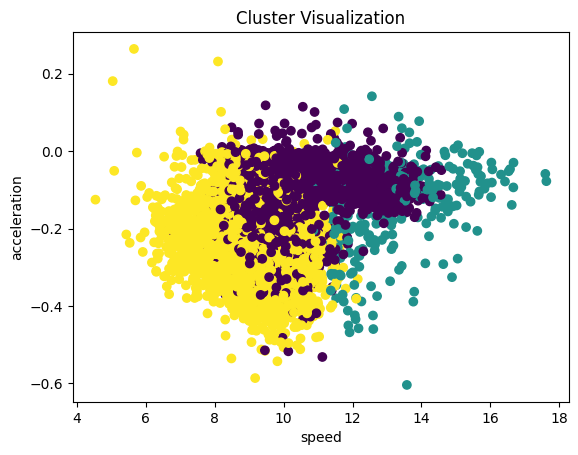

In [25]:
def draw_tid_clusters(data_with_clusters, x_axis, y_axis, cluster_labels, cluster_centers=None):
    # Visualize the clusters (for 2D data)
    plt.scatter(data_with_clusters[x_axis], data_with_clusters[y_axis], c=cluster_labels, cmap='viridis')
    if cluster_centers is not None:
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=100, c='red')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title('Cluster Visualization')
    plt.show()

# Make sure 'tid_cluster' is a list or 1D array
tid_cluster = Norm_clusters_data['cluster'].tolist()


# Now, call the draw_clusters function
draw_tid_clusters(Norm_clusters_data, 'speed', 'acceleration', tid_cluster)


In [26]:
Norm_clusters_data

,trip_id,deviceid,speed,acceleration,radial_acceleration,acceleration_der,cluster
0,2.0,116,10.442029,-0.033831,0.525809,-0.006193,0
1,4.0,116,9.267959,-0.034914,0.456913,-0.007488,0
2,6.0,116,9.805623,-0.039889,0.494066,-0.008129,0
3,8.0,116,10.559482,-0.047062,0.568303,-0.008942,0
4,10.0,116,10.010804,-0.073304,0.503961,-0.013631,0
...,...,...,...,...,...,...,...
6788,15882.0,1719,14.231254,-0.083692,3.279589,-0.044142,1
6789,15884.0,1719,13.829493,-0.102370,2.782408,-0.071694,1
6790,15887.0,1719,13.069780,-0.062478,2.294260,-0.045605,0
6791,15889.0,1719,12.774784,-0.066386,2.403224,-0.037522,0


In [27]:
import plotly.graph_objects as go

# Create a 3D scatter plot with reduced dot size
fig = go.Figure()

for cluster in Norm_clusters_data['cluster'].unique():
    cluster_data = Norm_clusters_data[Norm_clusters_data['cluster'] == cluster]
    fig.add_trace(go.Scatter3d(
        x=cluster_data['speed'],
        y=cluster_data['radial_acceleration'],
        z=cluster_data['acceleration'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=3),  # Adjust the size of the dots as needed
    ))

# Customize the layout
fig.update_layout(
    scene=dict(aspectmode='data'),
    title='Speed vs. Radial Acceleration vs. Acceleration'
)

# Show the interactive plot
fig.show()


In [28]:
Dict_of_clusters['norm_cluster']=Norm_clusters_data

In [29]:
def draw_clusters(data_with_clusters,x_axis,y_axis):
    # Visualize the clusters (for 2D data)
    plt.scatter(data_with_clusters[x_axis], data_with_clusters[y_axis], c=cluster_labels, cmap='viridis')
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=100, c='red')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title('Cluster Visualization')
    plt.show()


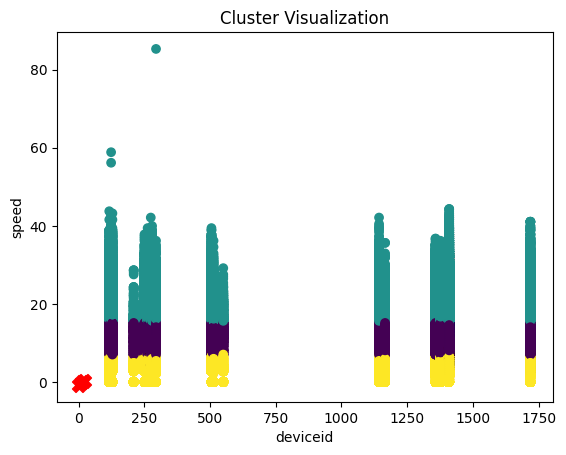

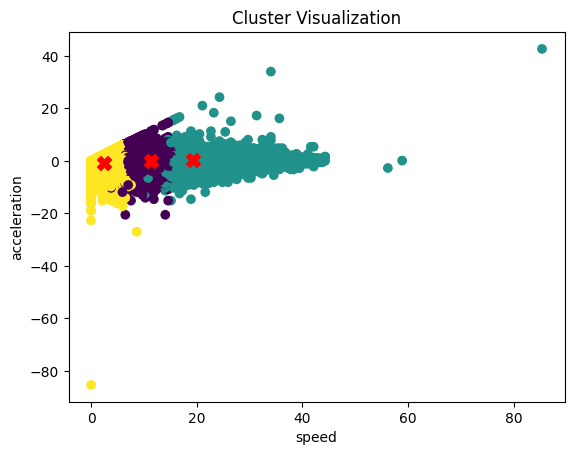

KeyboardInterrupt: 

In [30]:
draw_clusters(data_with_clusters,'deviceid','speed')
draw_clusters(data_with_clusters,'speed','acceleration')
draw_clusters(data_with_clusters,'speed','radial_acceleration')
draw_clusters(data_with_clusters,'speed','acceleration_der')

In [ ]:
average_values

In [ ]:
data_with_clusters

In [ ]:
import matplotlib.pyplot as plt

# Calculate average values for each cluster
average_values = data_with_clusters.groupby('cluster').mean()

# Plot bar graph for Average Speed
plt.bar(average_values.index, average_values['speed'])
plt.xlabel('Cluster')
plt.ylabel('Average Speed')
plt.title('Average Speed by Cluster')
plt.xticks(average_values.index)
plt.show()

# Plot bar graph for Average Acceleration
plt.bar(average_values.index, average_values['acceleration'])
plt.xlabel('Cluster')
plt.ylabel('Average Acceleration')
plt.title('Average Acceleration by Cluster')
plt.xticks(average_values.index)
plt.show()

# Plot bar graph for Average Radial Acceleration
plt.bar(average_values.index, average_values['radial_acceleration'])
plt.xlabel('Cluster')
plt.ylabel('Average Radial Acceleration')
plt.title('Average Radial Acceleration by Cluster')
plt.xticks(average_values.index)
plt.show()


# Cassificaton Modle

In [31]:
# save seg_cluster_vs_tid to csv
seg_cluster_vs_tid.to_csv('../DataOut/seg_cluster_vs_tid.csv', index=False)

In [32]:
bus_running_times_feature_added_all_moddedDF=pd.read_csv('../DataOut/bus_running_times_feature_added_all_moddedDF.csv')

In [33]:
# bus_running_times_feature_added_all_with_Kmeans_cluster = pd.merge(
#     left=bus_running_times_feature_added_all_moddedDF,
#     right=bus_trip_speed_and_other_features_grpd[['trip_id', 'segment', 'Kmeans_cluster']],
#     on=['trip_id', 'segment']
# ) do a left join like this

# left join bus_running_times_feature_added_all_moddedDF with bus_trip_speed_and_other_features_grpd[['trip_id', 'segment', 'Kmeans_cluster'] on trip_id and segment
bus_running_times_feature_added_all_with_Kmeans_cluster = pd.merge(
    left=bus_running_times_feature_added_all_moddedDF,
    right=seg_cluster_vs_tid[['trip_id', 'segment', 'norm_cluster']],
    on=['trip_id', 'segment'],
    how='left'
)

bus_running_times_feature_added_all_with_Kmeans_cluster


,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,conditions,dt(n-1),norm_cluster
0,4890.0,262.0,1.0,1.0,2021-10-01,06:39:49,06:40:58,0 days 00:01:09,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0,0.0
1,4890.0,262.0,1.0,2.0,2021-10-01,06:42:12,06:45:42,0 days 00:03:30,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,74.0,0.0
2,4890.0,262.0,1.0,3.0,2021-10-01,06:45:42,06:53:58,0 days 00:08:16,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0,0.0
3,4890.0,262.0,1.0,4.0,2021-10-01,06:54:04,06:57:19,0 days 00:03:15,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,6.0,1.0
4,4890.0,262.0,1.0,5.0,2021-10-01,06:57:19,06:58:56,0 days 00:01:37,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197627,3462.0,123.0,2.0,28.0,2022-10-31,18:45:44,18:47:23,0:01:39,99.0,0.8700,0.0,18.75,0.0,0,1,42.0,120.0,120.0,120.0,120.0,120.0,63.0,156.0,197.0,18.0,31.0,10.0,22.2,0.0,4.3,Partially cloudy,9.0,NaN
197628,3462.0,123.0,2.0,29.0,2022-10-31,18:47:38,18:50:23,0:02:45,165.0,1.4000,0.0,18.75,0.0,0,1,42.0,218.0,218.0,218.0,218.0,218.0,99.0,63.0,156.0,18.0,31.0,10.0,22.2,0.0,4.3,Partially cloudy,15.0,NaN
197629,3462.0,123.0,2.0,30.0,2022-10-31,18:50:56,18:56:33,0:05:37,337.0,2.5600,0.0,18.75,0.0,0,1,42.0,391.0,391.0,391.0,391.0,391.0,165.0,99.0,63.0,18.0,31.0,10.0,22.2,0.0,4.3,Partially cloudy,33.0,NaN
197630,3462.0,123.0,2.0,31.0,2022-10-31,18:56:48,18:57:34,0:00:46,46.0,0.4200,0.0,18.75,0.0,0,1,42.0,65.0,65.0,65.0,65.0,65.0,337.0,165.0,99.0,18.0,31.0,10.0,22.2,0.0,4.3,Partially cloudy,15.0,NaN


In [34]:
bus_running_times_feature_added_all_with_Kmeans_cluster = pd.merge(bus_running_times_feature_added_all_with_Kmeans_cluster, result_df, on='deviceid', how='inner')
# print all the nan values in each columns
print(bus_running_times_feature_added_all_with_Kmeans_cluster.isnull().sum())
bus_running_times_feature_added_all_with_Kmeans_cluster

trip_id                    0
deviceid                   0
direction                  0
segment                    0
date                       0
start_time                 0
end_time                   0
run_time                   0
run_time_in_seconds        0
length                     0
day_of_week                0
time_of_day                0
Sunday/holiday             0
saturday                   0
weekday/end                0
week_no                    0
rt(w-1)                    0
rt(w-2)                    0
rt(w-3)                    0
rt(t-1)                    0
rt(t-2)                    0
rt(n-1)                    0
rt(n-2)                    0
rt(n-3)                    0
hour_of_day                0
day                        0
month                      0
temp                       0
precip                     0
windspeed                  0
conditions                 0
dt(n-1)                    0
norm_cluster           97260
Cluster_0.0                0
Cluster_1.0   

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,conditions,dt(n-1),norm_cluster,Cluster_0.0,Cluster_1.0,Cluster_2.0
0,4890.0,262.0,1.0,1.0,2021-10-01,06:39:49,06:40:58,0 days 00:01:09,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0,0.0,33.0,11.0,55.0
1,4890.0,262.0,1.0,2.0,2021-10-01,06:42:12,06:45:42,0 days 00:03:30,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,74.0,0.0,33.0,11.0,55.0
2,4890.0,262.0,1.0,3.0,2021-10-01,06:45:42,06:53:58,0 days 00:08:16,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0,0.0,33.0,11.0,55.0
3,4890.0,262.0,1.0,4.0,2021-10-01,06:54:04,06:57:19,0 days 00:03:15,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,6.0,1.0,33.0,11.0,55.0
4,4890.0,262.0,1.0,5.0,2021-10-01,06:57:19,06:58:56,0 days 00:01:37,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0,1.0,33.0,11.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197627,9130.0,284.0,2.0,30.0,2022-10-28,08:15:31,08:24:03,0:08:32,512.0,2.5600,4.0,8.25,0.0,0,1,41.0,415.0,416.0,415.0,415.0,392.0,167.0,68.0,33.0,8.0,28.0,10.0,22.1,0.0,0.1,Partially cloudy,25.0,NaN,26.0,74.0,0.0
197628,9130.0,284.0,2.0,31.0,2022-10-28,08:24:18,08:25:04,0:00:46,46.0,0.4200,4.0,8.25,0.0,0,1,41.0,45.0,45.0,61.0,61.0,47.0,512.0,167.0,68.0,8.0,28.0,10.0,22.1,0.0,0.1,Partially cloudy,15.0,NaN,26.0,74.0,0.0
197629,9130.0,284.0,2.0,32.0,2022-10-28,08:25:29,08:28:56,0:03:27,207.0,1.3000,4.0,8.25,0.0,0,1,41.0,164.0,172.0,194.0,194.0,172.0,46.0,512.0,167.0,8.0,28.0,10.0,22.1,0.0,0.1,Partially cloudy,25.0,NaN,26.0,74.0,0.0
197630,9130.0,284.0,2.0,33.0,2022-10-28,08:29:42,08:33:06,0:03:24,204.0,1.2200,4.0,8.25,0.0,0,1,41.0,190.0,160.0,195.0,195.0,162.0,207.0,46.0,512.0,8.0,28.0,10.0,22.1,0.0,0.1,Partially cloudy,46.0,NaN,26.0,74.0,0.0


In [35]:
bus_running_times_feature_added_all_with_Kmeans_cluster.dropna(inplace=True)
# bus_running_times_feature_added_all_with_Kmeans_cluster

In [36]:
def prepare(df):
    df['date'] = pd.to_datetime(df['date'])
    df['start_time'] = pd.to_datetime(df['start_time'],
                                    format='%H:%M:%S').dt.time

    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    df.drop(['run_time'], axis=1,inplace = True)
    df.drop(['end_time'], axis=1,inplace = True)

    #replace ' partially cloudy' with 'partially cloudy'
    df['conditions'] = df['conditions'].replace(' Partially cloudy', 'Partially cloudy')


    from sklearn.preprocessing import OrdinalEncoder

    # Replace NaN values in the 'conditions' column with 'Unknown'
    df['conditions'].fillna('Unknown', inplace=True)

    conditions = ['Rain', 'Rain, Overcast', 'Rain, Partially cloudy', 'Overcast', 'Partially cloudy', 'Clear','Unknown']
    encoder = OrdinalEncoder(categories=[conditions])
    df['conditions_encoded'] = encoder.fit_transform(df[['conditions']])

    # Now, you can drop the original 'conditions' column if needed
    df = df.drop(['conditions'], axis=1)

    df['start_float'] = df['start_time'].apply(lambda x: x.hour + x.minute/60.0 + x.second/3600.0)

    # drop 
    df = df.drop(['start_time'], axis=1)

    # Drop the original date column
    df.drop('date', axis=1, inplace=True)
    
    return df

bus_running_times_feature_added_all_with_Kmeans_cluster=prepare(bus_running_times_feature_added_all_with_Kmeans_cluster)
bus_running_times_feature_added_all_with_Kmeans_cluster

,trip_id,deviceid,direction,segment,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1),norm_cluster,Cluster_0.0,Cluster_1.0,Cluster_2.0,year,conditions_encoded,start_float
0,4890.0,262.0,1.0,1.0,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1,10,20.0,0.0,6.1,0.0,0.0,33.0,11.0,55.0,2021,4.0,6.663611
1,4890.0,262.0,1.0,2.0,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1,10,20.0,0.0,6.1,74.0,0.0,33.0,11.0,55.0,2021,4.0,6.703333
2,4890.0,262.0,1.0,3.0,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1,10,20.0,0.0,6.1,0.0,0.0,33.0,11.0,55.0,2021,4.0,6.761667
3,4890.0,262.0,1.0,4.0,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1,10,20.0,0.0,6.1,6.0,1.0,33.0,11.0,55.0,2021,4.0,6.901111
4,4890.0,262.0,1.0,5.0,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1,10,20.0,0.0,6.1,0.0,1.0,33.0,11.0,55.0,2021,4.0,6.955278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197102,9131.0,284.0,1.0,11.0,97.0,1.1000,4.0,9.75,0.0,0,1,41.0,206.0,160.0,152.0,211.0,211.0,122.0,32.0,77.0,9.0,28,10,24.2,0.0,4.7,15.0,1.0,26.0,74.0,0.0,2022,5.0,9.921944
197103,9131.0,284.0,1.0,12.0,133.0,1.3100,4.0,9.75,0.0,0,1,41.0,150.0,139.0,181.0,180.0,156.0,97.0,122.0,32.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.948889
197104,9131.0,284.0,1.0,13.0,141.0,1.1500,4.0,9.75,0.0,0,1,41.0,168.0,106.0,178.0,159.0,133.0,133.0,97.0,122.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.985833
197105,9131.0,284.0,1.0,14.0,91.0,0.8900,4.0,10.00,0.0,0,1,41.0,120.0,107.0,105.0,107.0,117.0,141.0,133.0,97.0,10.0,28,10,25.8,0.0,6.8,0.0,1.0,26.0,74.0,0.0,2022,5.0,10.025000


In [37]:
# print the number of nan values in each clumn
print(bus_running_times_feature_added_all_with_Kmeans_cluster.isnull().sum())

trip_id                0
deviceid               0
direction              0
segment                0
run_time_in_seconds    0
length                 0
day_of_week            0
time_of_day            0
Sunday/holiday         0
saturday               0
weekday/end            0
week_no                0
rt(w-1)                0
rt(w-2)                0
rt(w-3)                0
rt(t-1)                0
rt(t-2)                0
rt(n-1)                0
rt(n-2)                0
rt(n-3)                0
hour_of_day            0
day                    0
month                  0
temp                   0
precip                 0
windspeed              0
dt(n-1)                0
norm_cluster           0
Cluster_0.0            0
Cluster_1.0            0
Cluster_2.0            0
year                   0
conditions_encoded     0
start_float            0
dtype: int64


In [38]:
# open csv avg_for_devID_time_of_day_and_segment.csv
avg_for_devID_time_of_day_and_segment = pd.read_csv('../DataOut/avg_for_devID_time_of_day_and_segment.csv')
# rename avg_for_devID_time_of_day_and_segment time_of_day column to dayparts
avg_for_devID_time_of_day_and_segment.rename(columns={'time_of_day': 'dayparts'}, inplace=True)
avg_for_devID_time_of_day_and_segment

,deviceid,dayparts,segment,speed,acceleration,radial_acceleration,throttle_count,break_count
0,116.0,morning,0,3.914116,-0.017456,0.265196,4.388889,2.555556
1,116.0,morning,1,6.617755,-0.022759,0.354919,1.444820,1.453245
2,116.0,morning,2,8.190476,0.021226,0.536539,3.344290,1.696848
3,116.0,morning,3,9.379045,-0.009781,0.627968,7.637994,6.356376
4,116.0,morning,4,13.073141,-0.028369,0.431310,4.018528,3.886830
...,...,...,...,...,...,...,...,...
2335,1719.0,night,30,12.734617,-0.056198,2.164006,67.990000,71.200000
2336,1719.0,night,31,9.778024,-0.116117,1.839681,15.607843,15.161765
2337,1719.0,night,32,10.840697,-0.041236,2.566036,36.789216,36.313725
2338,1719.0,night,33,10.507523,-0.030423,2.999890,41.034314,41.774510


In [39]:
# Create a new 'time_of_day' column based on the time component
bus_running_times_feature_added_all_with_Kmeans_cluster['dayparts'] = pd.cut(
    bus_running_times_feature_added_all_with_Kmeans_cluster['hour_of_day'],
    bins=[0, 6, 19, 24],
    labels=['morning', 'day', 'night'],
    include_lowest=True
)

In [40]:
# add data from avg_for_devID_time_of_day_and_segment to daf_with_features based on deviceid and dayparts
bus_running_times_feature_added_all_with_Kmeans_cluster = pd.merge(bus_running_times_feature_added_all_with_Kmeans_cluster, avg_for_devID_time_of_day_and_segment, on=['deviceid', 'dayparts','segment'], how='left')

In [41]:
# Create a custom mapping dictionary
dayparts_mapping = {'morning': 0, 'day': 1, 'night': 2}

# Use the map function to label encode 'dayparts' column
bus_running_times_feature_added_all_with_Kmeans_cluster['dayparts'] = bus_running_times_feature_added_all_with_Kmeans_cluster['dayparts'].map(dayparts_mapping)

In [42]:
bus_running_times_feature_added_all_with_Kmeans_cluster

,trip_id,deviceid,direction,segment,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1),norm_cluster,Cluster_0.0,Cluster_1.0,Cluster_2.0,year,conditions_encoded,start_float,dayparts,speed,acceleration,radial_acceleration,throttle_count,break_count
0,4890.0,262.0,1.0,1.0,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1,10,20.0,0.0,6.1,0.0,0.0,33.0,11.0,55.0,2021,4.0,6.663611,0,6.551622,-0.263065,0.289582,1.333333,0.333333
1,4890.0,262.0,1.0,2.0,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1,10,20.0,0.0,6.1,74.0,0.0,33.0,11.0,55.0,2021,4.0,6.703333,0,10.318498,-0.020071,0.876211,3.000000,1.000000
2,4890.0,262.0,1.0,3.0,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1,10,20.0,0.0,6.1,0.0,0.0,33.0,11.0,55.0,2021,4.0,6.761667,0,9.510959,-0.306166,0.668537,7.500000,8.250000
3,4890.0,262.0,1.0,4.0,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1,10,20.0,0.0,6.1,6.0,1.0,33.0,11.0,55.0,2021,4.0,6.901111,0,12.014774,-0.072601,0.425698,3.250000,3.750000
4,4890.0,262.0,1.0,5.0,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1,10,20.0,0.0,6.1,0.0,1.0,33.0,11.0,55.0,2021,4.0,6.955278,0,14.626720,-0.645813,0.374014,1.250000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100367,9131.0,284.0,1.0,11.0,97.0,1.1000,4.0,9.75,0.0,0,1,41.0,206.0,160.0,152.0,211.0,211.0,122.0,32.0,77.0,9.0,28,10,24.2,0.0,4.7,15.0,1.0,26.0,74.0,0.0,2022,5.0,9.921944,1,16.857172,-0.121372,3.783189,29.394737,30.894737
100368,9131.0,284.0,1.0,12.0,133.0,1.3100,4.0,9.75,0.0,0,1,41.0,150.0,139.0,181.0,180.0,156.0,97.0,122.0,32.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.948889,1,17.361381,-0.120115,3.513575,32.289474,34.315789
100369,9131.0,284.0,1.0,13.0,141.0,1.1500,4.0,9.75,0.0,0,1,41.0,168.0,106.0,178.0,159.0,133.0,133.0,97.0,122.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.985833,1,17.966975,-0.186211,3.638588,27.394737,29.105263
100370,9131.0,284.0,1.0,14.0,91.0,0.8900,4.0,10.00,0.0,0,1,41.0,120.0,107.0,105.0,107.0,117.0,141.0,133.0,97.0,10.0,28,10,25.8,0.0,6.8,0.0,1.0,26.0,74.0,0.0,2022,5.0,10.025000,1,16.828766,-0.207720,3.158288,20.236842,22.342105


In [43]:
# Define the split date
split_date= "2022-10-01"

# create a temperary date column using year, month, day column to use for splitting for test and tran datasets
bus_running_times_feature_added_all_with_Kmeans_cluster['temp_date'] = bus_running_times_feature_added_all_with_Kmeans_cluster['year'].astype(str) + '-' + bus_running_times_feature_added_all_with_Kmeans_cluster['month'].astype(str) + '-' + bus_running_times_feature_added_all_with_Kmeans_cluster['day'].astype(str)
# convert temp_date to datetime
bus_running_times_feature_added_all_with_Kmeans_cluster['temp_date'] = pd.to_datetime(bus_running_times_feature_added_all_with_Kmeans_cluster['temp_date'])
# convert split_date to datetime
split_date = pd.to_datetime(split_date)

In [44]:
# # min max scaler for bus_running_times_feature_added_all_with_Kmeans_cluster except trip_id,deviceid and segment
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# # get a list of all the features except trip_id,deviceid and segment
# features = bus_running_times_feature_added_all_with_Kmeans_cluster.columns.tolist()
# features.remove('trip_id')
# features.remove('deviceid')
# features.remove('segment')
# features.remove('temp_date')
# features.remove('norm_cluster')

# bus_running_times_feature_added_all_with_Kmeans_cluster[features] = scaler.fit_transform(bus_running_times_feature_added_all_with_Kmeans_cluster[features])

In [45]:
bus_running_times_feature_added_all_with_Kmeans_cluster

,trip_id,deviceid,direction,segment,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1),norm_cluster,Cluster_0.0,Cluster_1.0,Cluster_2.0,year,conditions_encoded,start_float,dayparts,speed,acceleration,radial_acceleration,throttle_count,break_count,temp_date
0,4890.0,262.0,1.0,1.0,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1,10,20.0,0.0,6.1,0.0,0.0,33.0,11.0,55.0,2021,4.0,6.663611,0,6.551622,-0.263065,0.289582,1.333333,0.333333,2021-10-01
1,4890.0,262.0,1.0,2.0,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1,10,20.0,0.0,6.1,74.0,0.0,33.0,11.0,55.0,2021,4.0,6.703333,0,10.318498,-0.020071,0.876211,3.000000,1.000000,2021-10-01
2,4890.0,262.0,1.0,3.0,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1,10,20.0,0.0,6.1,0.0,0.0,33.0,11.0,55.0,2021,4.0,6.761667,0,9.510959,-0.306166,0.668537,7.500000,8.250000,2021-10-01
3,4890.0,262.0,1.0,4.0,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1,10,20.0,0.0,6.1,6.0,1.0,33.0,11.0,55.0,2021,4.0,6.901111,0,12.014774,-0.072601,0.425698,3.250000,3.750000,2021-10-01
4,4890.0,262.0,1.0,5.0,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1,10,20.0,0.0,6.1,0.0,1.0,33.0,11.0,55.0,2021,4.0,6.955278,0,14.626720,-0.645813,0.374014,1.250000,1.000000,2021-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100367,9131.0,284.0,1.0,11.0,97.0,1.1000,4.0,9.75,0.0,0,1,41.0,206.0,160.0,152.0,211.0,211.0,122.0,32.0,77.0,9.0,28,10,24.2,0.0,4.7,15.0,1.0,26.0,74.0,0.0,2022,5.0,9.921944,1,16.857172,-0.121372,3.783189,29.394737,30.894737,2022-10-28
100368,9131.0,284.0,1.0,12.0,133.0,1.3100,4.0,9.75,0.0,0,1,41.0,150.0,139.0,181.0,180.0,156.0,97.0,122.0,32.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.948889,1,17.361381,-0.120115,3.513575,32.289474,34.315789,2022-10-28
100369,9131.0,284.0,1.0,13.0,141.0,1.1500,4.0,9.75,0.0,0,1,41.0,168.0,106.0,178.0,159.0,133.0,133.0,97.0,122.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.985833,1,17.966975,-0.186211,3.638588,27.394737,29.105263,2022-10-28
100370,9131.0,284.0,1.0,14.0,91.0,0.8900,4.0,10.00,0.0,0,1,41.0,120.0,107.0,105.0,107.0,117.0,141.0,133.0,97.0,10.0,28,10,25.8,0.0,6.8,0.0,1.0,26.0,74.0,0.0,2022,5.0,10.025000,1,16.828766,-0.207720,3.158288,20.236842,22.342105,2022-10-28


In [46]:
# in bus_running_times_feature_added_all_with_Kmeans_clusterfor create a new column cll "cluster_in_segment_before" that cntain the cluster of the previous segment of the same trip_id
bus_running_times_feature_added_all_with_Kmeans_cluster['cluster_in_1_segment_before'] = bus_running_times_feature_added_all_with_Kmeans_cluster.groupby(['trip_id'])['norm_cluster'].shift(1)
bus_running_times_feature_added_all_with_Kmeans_cluster['cluster_in_2_segment_before'] = bus_running_times_feature_added_all_with_Kmeans_cluster.groupby(['trip_id'])['norm_cluster'].shift(2)
bus_running_times_feature_added_all_with_Kmeans_cluster['cluster_in_3_segment_before'] = bus_running_times_feature_added_all_with_Kmeans_cluster.groupby(['trip_id'])['norm_cluster'].shift(3)

In [47]:
# read DataOut\bus_trip_all_points_with_acceleration_and_radial_acceleration_and_distance_and_accDiff.csv
bus_trip_speed_and_other_features_with_segs = pd.read_csv('../DataOut/bus_trip_speed_and_other_features.csv')
bus_trip_speed_and_other_features_with_segs

,deviceid,devicetime,latitude,longitude,speed,date,time,bus_stop,trip_id,direction,acceleration,radial_acceleration,distance_from_start,time_diff,acc_diff,acceleration_der,segment
0,116,2021-10-16 08:03:19,7.293068,80.636430,14.03890,2021-10-16,08:03:19,0,2.0,1,0.323975,0.000000,0.000000,NaN,NaN,0.000000,1
1,116,2021-10-16 08:03:34,7.293043,80.637552,10.25920,2021-10-16,08:03:34,0,2.0,1,-0.251980,1.278067,123.738485,0 days 00:00:15,-0.575955,-0.038397,1
2,116,2021-10-16 08:03:49,7.292725,80.637707,7.55940,2021-10-16,08:03:49,0,2.0,1,-0.179987,0.722300,163.044397,0 days 00:00:15,0.071993,0.004800,1
3,116,2021-10-16 08:04:04,7.292292,80.637663,3.77970,2021-10-16,08:04:04,0,2.0,1,-0.251980,0.048332,211.472339,0 days 00:00:15,-0.071993,-0.004800,1
4,116,2021-10-16 08:04:19,7.291640,80.637455,9.17927,2021-10-16,08:04:19,101,2.0,1,0.359971,1.052222,287.492821,0 days 00:00:15,0.611951,0.040797,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034419,1719,2022-02-25 16:47:53,7.291572,80.635452,2.15983,2022-02-25,16:47:53,0,15890.0,2,0.215983,0.714925,16242.694984,0 days 00:00:10,2.105833,0.210583,0
4034420,1719,2022-02-25 16:47:57,7.291587,80.635355,2.15983,2022-02-25,16:47:57,0,15890.0,2,0.000000,0.003500,16253.479312,0 days 00:00:04,-0.215983,-0.053996,0
4034421,1719,2022-02-25 16:48:02,7.291597,80.635293,3.77970,2022-02-25,16:48:02,0,15890.0,2,0.323974,1.320196,16260.374802,0 days 00:00:05,0.323974,0.064795,0
4034422,1719,2022-02-25 16:48:03,7.291605,80.635280,3.77970,2022-02-25,16:48:03,0,15890.0,2,0.000000,0.128080,16262.113859,0 days 00:00:01,-0.323974,-0.323974,0


In [48]:
# Select specific columns for grouping
selected_columns = ['trip_id', 'segment', 'speed', 'acceleration', 'radial_acceleration', 'acceleration_der']

# Group by 'trip_id' and 'segment', calculate the mean, and reset the index
bus_trip_speed_and_other_features_with_segs_grpd = bus_trip_speed_and_other_features_with_segs[selected_columns].groupby(['trip_id', 'segment']).mean().reset_index()
bus_trip_speed_and_other_features_with_segs_grpd

,trip_id,segment,speed,acceleration,radial_acceleration,acceleration_der
0,1.0,0,1.208475,0.070280,0.017025,0.020962
1,1.0,21,14.518853,-0.189485,1.359669,-0.040117
2,1.0,22,20.698367,-0.391683,1.134855,-0.028528
3,1.0,23,12.222668,0.000099,0.487629,-0.002348
4,1.0,24,9.584235,0.008999,0.471313,-0.001950
...,...,...,...,...,...,...
207381,15891.0,11,18.699291,-0.152594,3.907671,-0.068174
207382,15891.0,12,16.473428,-0.152041,2.910918,-0.152096
207383,15891.0,13,17.021033,-0.189728,3.823469,-0.091171
207384,15891.0,14,10.994308,-0.172396,2.093276,-0.152880


In [49]:
bus_trip_speed_and_other_features_with_segs_grpd['speed_1_segment_before'] = bus_trip_speed_and_other_features_with_segs_grpd.groupby(['trip_id'])['speed'].shift(1)


bus_trip_speed_and_other_features_with_segs_grpd

,trip_id,segment,speed,acceleration,radial_acceleration,acceleration_der,speed_1_segment_before
0,1.0,0,1.208475,0.070280,0.017025,0.020962,NaN
1,1.0,21,14.518853,-0.189485,1.359669,-0.040117,1.208475
2,1.0,22,20.698367,-0.391683,1.134855,-0.028528,14.518853
3,1.0,23,12.222668,0.000099,0.487629,-0.002348,20.698367
4,1.0,24,9.584235,0.008999,0.471313,-0.001950,12.222668
...,...,...,...,...,...,...,...
207381,15891.0,11,18.699291,-0.152594,3.907671,-0.068174,21.137347
207382,15891.0,12,16.473428,-0.152041,2.910918,-0.152096,18.699291
207383,15891.0,13,17.021033,-0.189728,3.823469,-0.091171,16.473428
207384,15891.0,14,10.994308,-0.172396,2.093276,-0.152880,17.021033


In [50]:
# left join bus_running_times_feature_added_all_with_Kmeans_cluster with bus_trip_speed_and_other_features_with_segs_grpd's 'speed_1_segment_before' column on trip_id and segment
bus_running_times_feature_added_all_with_Kmeans_cluster = pd.merge(
    left=bus_running_times_feature_added_all_with_Kmeans_cluster,
    right=bus_trip_speed_and_other_features_with_segs_grpd[['trip_id', 'segment', 'speed_1_segment_before']],
    on=['trip_id', 'segment'],
    how='left'
)

In [51]:
previous_trip_segments = {}

for index, row in bus_running_times_feature_added_all_with_Kmeans_cluster.iterrows():
    trip_id = row['trip_id']
    device_id = row['deviceid']
    segment = row['segment']
    norm_cluster = row['norm_cluster']

    if device_id in previous_trip_segments and segment in previous_trip_segments[device_id]:
        # Get the cluster label from the previous trip's corresponding segment
        norm_cluster_from_previous_trip = previous_trip_segments[device_id][segment]
        bus_running_times_feature_added_all_with_Kmeans_cluster.at[index, 'last_trip_cluster'] = norm_cluster_from_previous_trip

    # Store the segment and its cluster label for the current trip
    if device_id not in previous_trip_segments:
        previous_trip_segments[device_id] = {}
    previous_trip_segments[device_id][segment] = norm_cluster


In [52]:
bus_running_times_feature_added_all_with_Kmeans_cluster

,trip_id,deviceid,direction,segment,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1),norm_cluster,Cluster_0.0,Cluster_1.0,Cluster_2.0,year,conditions_encoded,start_float,dayparts,speed,acceleration,radial_acceleration,throttle_count,break_count,temp_date,cluster_in_1_segment_before,cluster_in_2_segment_before,cluster_in_3_segment_before,speed_1_segment_before,last_trip_cluster
0,4890.0,262.0,1.0,1.0,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1,10,20.0,0.0,6.1,0.0,0.0,33.0,11.0,55.0,2021,4.0,6.663611,0,6.551622,-0.263065,0.289582,1.333333,0.333333,2021-10-01,NaN,NaN,NaN,4.117171,NaN
1,4890.0,262.0,1.0,2.0,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1,10,20.0,0.0,6.1,74.0,0.0,33.0,11.0,55.0,2021,4.0,6.703333,0,10.318498,-0.020071,0.876211,3.000000,1.000000,2021-10-01,0.0,NaN,NaN,10.475160,NaN
2,4890.0,262.0,1.0,3.0,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1,10,20.0,0.0,6.1,0.0,0.0,33.0,11.0,55.0,2021,4.0,6.761667,0,9.510959,-0.306166,0.668537,7.500000,8.250000,2021-10-01,0.0,0.0,NaN,7.991364,NaN
3,4890.0,262.0,1.0,4.0,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1,10,20.0,0.0,6.1,6.0,1.0,33.0,11.0,55.0,2021,4.0,6.901111,0,12.014774,-0.072601,0.425698,3.250000,3.750000,2021-10-01,0.0,0.0,0.0,7.590256,NaN
4,4890.0,262.0,1.0,5.0,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1,10,20.0,0.0,6.1,0.0,1.0,33.0,11.0,55.0,2021,4.0,6.955278,0,14.626720,-0.645813,0.374014,1.250000,1.000000,2021-10-01,1.0,0.0,0.0,14.463141,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100367,9131.0,284.0,1.0,11.0,97.0,1.1000,4.0,9.75,0.0,0,1,41.0,206.0,160.0,152.0,211.0,211.0,122.0,32.0,77.0,9.0,28,10,24.2,0.0,4.7,15.0,1.0,26.0,74.0,0.0,2022,5.0,9.921944,1,16.857172,-0.121372,3.783189,29.394737,30.894737,2022-10-28,1.0,1.0,1.0,20.523937,1.0
100368,9131.0,284.0,1.0,12.0,133.0,1.3100,4.0,9.75,0.0,0,1,41.0,150.0,139.0,181.0,180.0,156.0,97.0,122.0,32.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.948889,1,17.361381,-0.120115,3.513575,32.289474,34.315789,2022-10-28,1.0,1.0,1.0,18.484769,1.0
100369,9131.0,284.0,1.0,13.0,141.0,1.1500,4.0,9.75,0.0,0,1,41.0,168.0,106.0,178.0,159.0,133.0,133.0,97.0,122.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.985833,1,17.966975,-0.186211,3.638588,27.394737,29.105263,2022-10-28,1.0,1.0,1.0,19.531022,1.0
100370,9131.0,284.0,1.0,14.0,91.0,0.8900,4.0,10.00,0.0,0,1,41.0,120.0,107.0,105.0,107.0,117.0,141.0,133.0,97.0,10.0,28,10,25.8,0.0,6.8,0.0,1.0,26.0,74.0,0.0,2022,5.0,10.025000,1,16.828766,-0.207720,3.158288,20.236842,22.342105,2022-10-28,1.0,1.0,1.0,18.599116,1.0


In [53]:
# print the number of nan values in each clumn
print(bus_running_times_feature_added_all_with_Kmeans_cluster.isnull().sum())

trip_id                            0
deviceid                           0
direction                          0
segment                            0
run_time_in_seconds                0
length                             0
day_of_week                        0
time_of_day                        0
Sunday/holiday                     0
saturday                           0
weekday/end                        0
week_no                            0
rt(w-1)                            0
rt(w-2)                            0
rt(w-3)                            0
rt(t-1)                            0
rt(t-2)                            0
rt(n-1)                            0
rt(n-2)                            0
rt(n-3)                            0
hour_of_day                        0
day                                0
month                              0
temp                               0
precip                             0
windspeed                          0
dt(n-1)                            0
n

In [54]:
# split test and train datasets
temp_train_data = bus_running_times_feature_added_all_with_Kmeans_cluster[bus_running_times_feature_added_all_with_Kmeans_cluster['temp_date'] < split_date]

In [55]:
# group norm cluster by deviceid,segment,and dayparts and get the mode of norm cluster (if more than one mode get the first one)
norm_cluster_mode_did_seg_dp = temp_train_data.groupby(['deviceid','segment','dayparts'])['norm_cluster'].agg(lambda x:x.value_counts().index[0]).reset_index()
# rename norm_cluster to norm_cluster_mode
norm_cluster_mode_did_seg_dp.rename(columns={'norm_cluster': 'norm_cluster_mode_did_seg_dp'}, inplace=True)
norm_cluster_mode_did_seg_dp

,deviceid,segment,dayparts,norm_cluster_mode_did_seg_dp
0,116.0,1.0,0,2.0
1,116.0,1.0,1,2.0
2,116.0,1.0,2,0.0
3,116.0,2.0,1,0.0
4,116.0,2.0,2,0.0
...,...,...,...,...
719,1719.0,11.0,1,1.0
720,1719.0,12.0,1,1.0
721,1719.0,13.0,1,1.0
722,1719.0,14.0,1,1.0


In [56]:
# group norm cluster by deviceid,segment,and dayparts and get the mode of norm cluster (if more than one mode get the first one)
norm_cluster_mode_did_seg = temp_train_data.groupby(['deviceid','segment'])['norm_cluster'].agg(lambda x:x.value_counts().index[0]).reset_index()
# rename norm_cluster to norm_cluster_mode
norm_cluster_mode_did_seg.rename(columns={'norm_cluster': 'norm_cluster_mode_did_seg'}, inplace=True)
norm_cluster_mode_did_seg

,deviceid,segment,norm_cluster_mode_did_seg
0,116.0,1.0,2.0
1,116.0,2.0,0.0
2,116.0,3.0,0.0
3,116.0,4.0,0.0
4,116.0,5.0,0.0
...,...,...,...
370,1719.0,11.0,1.0
371,1719.0,12.0,1.0
372,1719.0,13.0,1.0
373,1719.0,14.0,1.0


In [57]:
# group norm cluster by deviceid,segment,and dayparts and get the mode of norm cluster (if more than one mode get the first one)
norm_cluster_mode_seg = temp_train_data.groupby(['segment'])['norm_cluster'].agg(lambda x:x.value_counts().index[0]).reset_index()
# rename norm_cluster to norm_cluster_mode
norm_cluster_mode_seg.rename(columns={'norm_cluster': 'norm_cluster_mode_seg'}, inplace=True)
norm_cluster_mode_seg

,segment,norm_cluster_mode_seg
0,1.0,2.0
1,2.0,0.0
2,3.0,0.0
3,4.0,0.0
4,5.0,2.0
5,6.0,0.0
6,7.0,0.0
7,8.0,0.0
8,9.0,1.0
9,10.0,0.0


In [58]:
# left join test_data with norm_cluster_mode_did_seg_dp on deviceid,segment,and dayparts

bus_running_times_feature_added_all_with_Kmeans_cluster= pd.merge(bus_running_times_feature_added_all_with_Kmeans_cluster, norm_cluster_mode_did_seg_dp, on=['deviceid','segment','dayparts'], how='left')

bus_running_times_feature_added_all_with_Kmeans_cluster = pd.merge(bus_running_times_feature_added_all_with_Kmeans_cluster, norm_cluster_mode_did_seg, on=['deviceid','segment'], how='left')

bus_running_times_feature_added_all_with_Kmeans_cluster = pd.merge(bus_running_times_feature_added_all_with_Kmeans_cluster, norm_cluster_mode_seg, on=['segment'], how='left')

# in test_data df, fill the nan values of norm_cluster_mode_did_seg_dp with the values in norm_cluster_mode_did_seg
bus_running_times_feature_added_all_with_Kmeans_cluster['norm_cluster_mode_did_seg_dp'].fillna(bus_running_times_feature_added_all_with_Kmeans_cluster['norm_cluster_mode_did_seg'], inplace=True)
bus_running_times_feature_added_all_with_Kmeans_cluster['norm_cluster_mode_did_seg_dp'].fillna(bus_running_times_feature_added_all_with_Kmeans_cluster['norm_cluster_mode_seg'], inplace=True)

bus_running_times_feature_added_all_with_Kmeans_cluster.isnull().sum()
# drop norm_cluster_mode_did_seg and norm_cluster_mode_seg columns
bus_running_times_feature_added_all_with_Kmeans_cluster.drop(['norm_cluster_mode_did_seg','norm_cluster_mode_seg'], axis=1, inplace=True)

# rename norm_cluster_mode_did_seg_dp to norm_cluster_mode
bus_running_times_feature_added_all_with_Kmeans_cluster.rename(columns={'norm_cluster_mode_did_seg_dp': 'norm_cluster_mode'}, inplace=True)

In [59]:
# split test and train datasets
train_data = bus_running_times_feature_added_all_with_Kmeans_cluster[bus_running_times_feature_added_all_with_Kmeans_cluster['temp_date'] < split_date]
test_data = bus_running_times_feature_added_all_with_Kmeans_cluster[bus_running_times_feature_added_all_with_Kmeans_cluster['temp_date'] >= split_date]

# randomly remowe 7000 rows from train_data where Kmeans_cluster is 2.0
# train_data = train_data.drop(train_data[(train_data['Kmeans_cluster'] == 2.0)].sample(n=80000).index)

# drop temp_date column
train_data = train_data.drop(columns=['temp_date'])
test_data = test_data.drop(columns=['temp_date'])
bus_running_times_feature_added_all_with_Kmeans_cluster=bus_running_times_feature_added_all_with_Kmeans_cluster.drop(columns=['temp_date'])

# Separate features and labels
X_train = train_data.drop(columns=['norm_cluster', 'trip_id','run_time_in_seconds'])
y_train = train_data['norm_cluster']
X_test = test_data.drop(columns=['norm_cluster', 'trip_id','run_time_in_seconds'])
y_test = test_data['norm_cluster']

In [60]:

# check the number of each cluster lables in train_data
train_data['norm_cluster'].value_counts()


norm_cluster
0.0    35513
2.0    28834
1.0    23268
Name: count, dtype: int64

In [61]:
# print the sizes of test and train data
print(f"Train data size: {X_train.shape}")
print(f"Test data size: {X_test.shape}")

# get the sum of row count of train and test data
print(f"Total data size: {X_train.shape[0] + X_test.shape[0]}")
# print the original size of bus_running_times_feature_added_all_with_Kmeans_cluster 
print(f"Original data size: {bus_running_times_feature_added_all_with_Kmeans_cluster.shape}")

Train data size: (87615, 43)
Test data size: (12757, 43)
Total data size: 100372
Original data size: (100372, 46)


In [62]:
X_train

,deviceid,direction,segment,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1),Cluster_0.0,Cluster_1.0,Cluster_2.0,year,conditions_encoded,start_float,dayparts,speed,acceleration,radial_acceleration,throttle_count,break_count,cluster_in_1_segment_before,cluster_in_2_segment_before,cluster_in_3_segment_before,speed_1_segment_before,last_trip_cluster,norm_cluster_mode
0,262.0,1.0,1.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1,10,20.0,0.000,6.1,0.0,33.0,11.0,55.0,2021,4.0,6.663611,0,6.551622,-0.263065,0.289582,1.333333,0.333333,NaN,NaN,NaN,4.117171,NaN,0.0
1,262.0,1.0,2.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1,10,20.0,0.000,6.1,74.0,33.0,11.0,55.0,2021,4.0,6.703333,0,10.318498,-0.020071,0.876211,3.000000,1.000000,0.0,NaN,NaN,10.475160,NaN,0.0
2,262.0,1.0,3.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1,10,20.0,0.000,6.1,0.0,33.0,11.0,55.0,2021,4.0,6.761667,0,9.510959,-0.306166,0.668537,7.500000,8.250000,0.0,0.0,NaN,7.991364,NaN,2.0
3,262.0,1.0,4.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1,10,20.0,0.000,6.1,6.0,33.0,11.0,55.0,2021,4.0,6.901111,0,12.014774,-0.072601,0.425698,3.250000,3.750000,0.0,0.0,0.0,7.590256,NaN,1.0
4,262.0,1.0,5.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1,10,20.0,0.000,6.1,0.0,33.0,11.0,55.0,2021,4.0,6.955278,0,14.626720,-0.645813,0.374014,1.250000,1.000000,1.0,0.0,0.0,14.463141,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99164,1166.0,1.0,11.0,1.1000,3.0,11.50,0.0,0,1,37.0,121.0,223.0,182.0,199.0,377.0,210.0,30.0,135.0,11.0,29,9,26.1,0.288,1.9,45.0,89.0,6.0,5.0,2022,2.0,11.629722,1,11.908836,0.015392,0.497679,2.924051,2.822785,0.0,0.0,2.0,11.531939,2.0,1.0
99165,1166.0,1.0,12.0,1.3100,3.0,11.50,0.0,0,1,37.0,125.0,184.0,179.0,191.0,210.0,160.0,210.0,30.0,11.0,29,9,26.1,0.288,1.9,15.0,89.0,6.0,5.0,2022,2.0,11.678333,1,12.900675,-0.066828,0.759997,3.243590,3.256410,1.0,0.0,0.0,11.609086,0.0,0.0
99166,1166.0,1.0,13.0,1.1500,3.0,11.50,0.0,0,1,37.0,86.0,155.0,137.0,126.0,143.0,217.0,160.0,210.0,11.0,29,9,26.1,0.288,1.9,15.0,89.0,6.0,5.0,2022,2.0,11.742778,1,13.207598,-0.117478,0.741766,2.610390,2.740260,0.0,1.0,0.0,10.326675,1.0,1.0
99167,1166.0,1.0,14.0,0.8900,3.0,11.75,0.0,0,1,37.0,80.0,137.0,111.0,88.0,116.0,165.0,217.0,160.0,11.0,29,9,26.1,0.288,1.9,15.0,89.0,6.0,5.0,2022,2.0,11.792778,1,12.271307,-0.075201,0.556260,1.961538,1.884615,0.0,0.0,1.0,11.564087,0.0,0.0


In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier


# Step 3: Train the XGBoost Model
xgb = XGBClassifier(colsample_bytree= 0.860672343510452, 
                    gamma= 2.666752729274489, 
                    learning_rate= 0.044451203099543625, 
                    max_depth= 13, 
                    min_child_weight= 8, 
                    n_estimators= 186, 
                    subsample= 0.8101444212804555)

# Then, train your model and evaluate it as you did in your previous code.

xgb.fit(X_train, y_train)

# Step 4: Evaluate the Model
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# Step 5 : Save the Model
# export best xgboost model
import pickle
pickle.dump(xgb, open('../ModelOut/Segemnt_Cluster_Classifier.sav', 'wb'))


# Step 6: Predict on Test Data
predicted_labels = xgb.predict(X_test)

# Step 7: Create a New DataFrame for Test Data with Predicted Values
test_data['Predicted_Kmeans_cluster'] = predicted_labels


Accuracy: 0.6184055812495101
Classification Report:
               precision    recall  f1-score   support

         0.0       0.61      0.68      0.65      4238
         1.0       0.63      0.51      0.56      3851
         2.0       0.62      0.65      0.63      4668

    accuracy                           0.62     12757
   macro avg       0.62      0.61      0.61     12757
weighted avg       0.62      0.62      0.62     12757



In [64]:
# Accuracy: 0.6147511202615962

# Accuracy: 0.6165677606879012

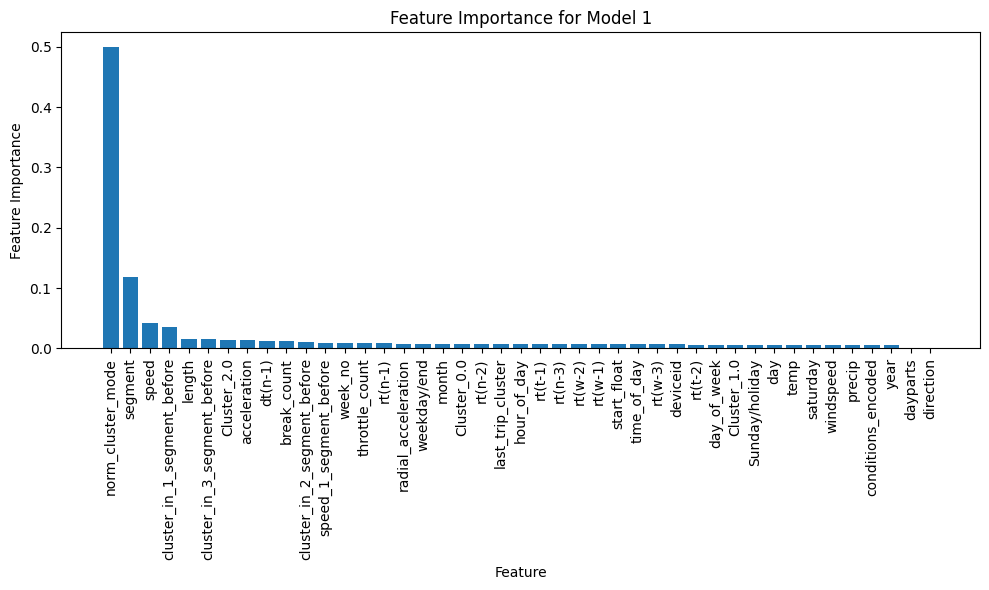

In [65]:
import matplotlib.pyplot as plt

# Get feature importances for Model 1
feature_importance1 = xgb.feature_importances_

# Get the names of the features
feature_names1 = X_train.columns

# Sort feature importances and feature names in descending order
sorted_idx1 = feature_importance1.argsort()[::-1]
feature_importance1 = feature_importance1[sorted_idx1]
feature_names1 = feature_names1[sorted_idx1]

# Create a bar graph for Model 1
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance1)), feature_importance1, align='center')
plt.xticks(range(len(feature_importance1)), feature_names1, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for Model 1')
plt.tight_layout()
plt.show()


In [66]:
# from sklearn.model_selection import RandomizedSearchCV
# from xgboost import XGBClassifier
# import scipy.stats
# from sklearn.metrics import accuracy_score

# # Define the target accuracy value
# target_accuracy = 0.62 # Adjust this to your desired accuracy
# iteration=0
# while True:
#     iteration=iteration+1
#     # Define the hyperparameters grid with a broader range of values
#     param_dist = {
#         'n_estimators': scipy.stats.randint(50, 1000),
#         'max_depth': scipy.stats.randint(2, 15),
#         'learning_rate': scipy.stats.uniform(0.01, 0.8),
#         'subsample': scipy.stats.uniform(0.4, 1.0),
#         'colsample_bytree': scipy.stats.uniform(0, 1),  # Adjusted the range
#         'gamma': scipy.stats.uniform(0, 5),
#         'min_child_weight': scipy.stats.randint(1, 10),
#         # Add other hyperparameters you want to tune
#     }


#     # Create the XGBoost classifier
#     xgb = XGBClassifier()

#     # Create the RandomizedSearchCV object
#     random_search = RandomizedSearchCV(
#         estimator=xgb,
#         param_distributions=param_dist,
#         scoring='accuracy',
#         # cv=3,
#         n_jobs=14,
#         n_iter=10,
#         verbose=2
#     )

#     # Perform the randomized search
#     random_search.fit(X_train, y_train)

#     # Get the best parameters
#     best_params = random_search.best_params_
#     print("Best Hyperparameters:", best_params)

#     # Evaluate the model with the best parameters
#     best_xgb = random_search.best_estimator_
#     y_pred_best = best_xgb.predict(X_test)
#     accuracy_best = accuracy_score(y_test, y_pred_best)
#     report_best = classification_report(y_test, y_pred_best)

#     print(f"iteration {iteration}")
#     print("Best XGBoost Accuracy:", accuracy_best)
#     print("Best XGBoost Classification Report:\n", report_best)

    
#     # Check if the achieved accuracy is greater than or equal to the target accuracy
#     if accuracy_best >= target_accuracy:
#         break  # Exit the loop

# print("Desired accuracy achieved!")


In [67]:
# from sklearn.model_selection import GridSearchCV

# # Define the hyperparameters grid
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 300, 500],
#     # Add other hyperparameters you want to tune
# }

# # Create the XGBoost classifier
# xgb = XGBClassifier()

# # Create the GridSearchCV object
# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# # Perform the grid search
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)


In [68]:
y_train

0        0.0
1        0.0
2        0.0
3        1.0
4        1.0
        ... 
99164    1.0
99165    0.0
99166    0.0
99167    0.0
99168    0.0
Name: norm_cluster, Length: 87615, dtype: float64

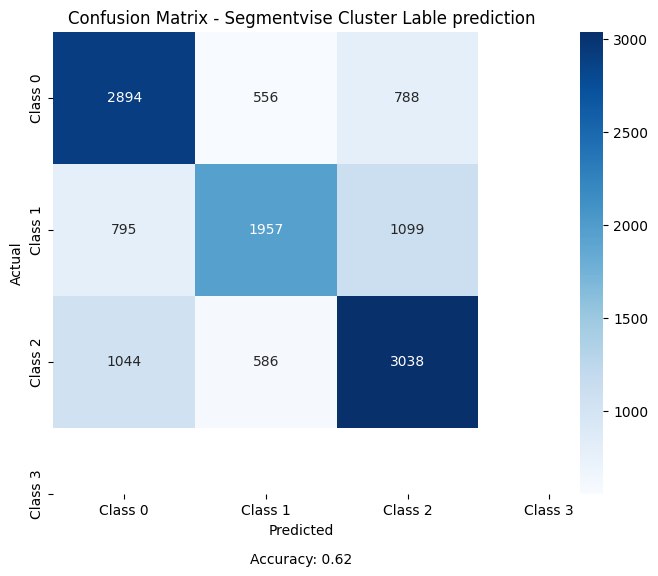

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test contains actual labels and y_pred contains predicted labels
confusion = confusion_matrix(y_test, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2','Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2','Class 3'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Segmentvise Cluster Lable prediction')

# Annotate the accuracy value at the bottom of the graph
plt.annotate(f'Accuracy: {accuracy:.2f}', (0.5, -0.15), xycoords='axes fraction', ha='center')

plt.show()


In [70]:
# from test_ data drop the Kmeans_cluster column and rename the Predicted_Kmeans_cluster column to Kmeans_cluster
test_data.drop('norm_cluster',axis=1,inplace=True)
test_data.rename(columns={'Predicted_Kmeans_cluster':'norm_cluster'},inplace=True)

In [71]:
# concatanate train_data and test_data
bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test = pd.concat([train_data,test_data])
bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test

,trip_id,deviceid,direction,segment,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1),norm_cluster,Cluster_0.0,Cluster_1.0,Cluster_2.0,year,conditions_encoded,start_float,dayparts,speed,acceleration,radial_acceleration,throttle_count,break_count,cluster_in_1_segment_before,cluster_in_2_segment_before,cluster_in_3_segment_before,speed_1_segment_before,last_trip_cluster,norm_cluster_mode
0,4890.0,262.0,1.0,1.0,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1,10,20.0,0.0,6.1,0.0,0.0,33.0,11.0,55.0,2021,4.0,6.663611,0,6.551622,-0.263065,0.289582,1.333333,0.333333,NaN,NaN,NaN,4.117171,NaN,0.0
1,4890.0,262.0,1.0,2.0,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1,10,20.0,0.0,6.1,74.0,0.0,33.0,11.0,55.0,2021,4.0,6.703333,0,10.318498,-0.020071,0.876211,3.000000,1.000000,0.0,NaN,NaN,10.475160,NaN,0.0
2,4890.0,262.0,1.0,3.0,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1,10,20.0,0.0,6.1,0.0,0.0,33.0,11.0,55.0,2021,4.0,6.761667,0,9.510959,-0.306166,0.668537,7.500000,8.250000,0.0,0.0,NaN,7.991364,NaN,2.0
3,4890.0,262.0,1.0,4.0,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1,10,20.0,0.0,6.1,6.0,1.0,33.0,11.0,55.0,2021,4.0,6.901111,0,12.014774,-0.072601,0.425698,3.250000,3.750000,0.0,0.0,0.0,7.590256,NaN,1.0
4,4890.0,262.0,1.0,5.0,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1,10,20.0,0.0,6.1,0.0,1.0,33.0,11.0,55.0,2021,4.0,6.955278,0,14.626720,-0.645813,0.374014,1.250000,1.000000,1.0,0.0,0.0,14.463141,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100367,9131.0,284.0,1.0,11.0,97.0,1.1000,4.0,9.75,0.0,0,1,41.0,206.0,160.0,152.0,211.0,211.0,122.0,32.0,77.0,9.0,28,10,24.2,0.0,4.7,15.0,1.0,26.0,74.0,0.0,2022,5.0,9.921944,1,16.857172,-0.121372,3.783189,29.394737,30.894737,1.0,1.0,1.0,20.523937,1.0,2.0
100368,9131.0,284.0,1.0,12.0,133.0,1.3100,4.0,9.75,0.0,0,1,41.0,150.0,139.0,181.0,180.0,156.0,97.0,122.0,32.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.948889,1,17.361381,-0.120115,3.513575,32.289474,34.315789,1.0,1.0,1.0,18.484769,1.0,1.0
100369,9131.0,284.0,1.0,13.0,141.0,1.1500,4.0,9.75,0.0,0,1,41.0,168.0,106.0,178.0,159.0,133.0,133.0,97.0,122.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.985833,1,17.966975,-0.186211,3.638588,27.394737,29.105263,1.0,1.0,1.0,19.531022,1.0,1.0
100370,9131.0,284.0,1.0,14.0,91.0,0.8900,4.0,10.00,0.0,0,1,41.0,120.0,107.0,105.0,107.0,117.0,141.0,133.0,97.0,10.0,28,10,25.8,0.0,6.8,0.0,1.0,26.0,74.0,0.0,2022,5.0,10.025000,1,16.828766,-0.207720,3.158288,20.236842,22.342105,1.0,1.0,1.0,18.599116,1.0,1.0


In [72]:
# save bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test to a csv
bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test.to_csv('../DataOut/bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test_normway.csv',index=False)